In [ ]:
# Upload manual via Colab (alternatif jika belum lewat Google Drive)
from google.colab import files
uploaded = files.upload()


Saving dataset_capstone_cleaned.csv to dataset_capstone_cleaned.csv


In [ ]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('capstone_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [ ]:
import pandas as pd

df = pd.read_csv("dataset_capstone_cleaned.csv")
tweets = df['clean_text'].dropna().tolist()

def split_batches(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

batches = split_batches(tweets, batch_size=10)


In [ ]:
def build_prompt(batch):
    tweet_lines = "\n".join([f"Tweet #{i+1}: {text}" for i, text in enumerate(batch)])
    return f"""
You are an AI trained to analyze Indonesian student tweets about jobs and economic issues.

For each tweet, classify:
1. Sentiment: Positive / Negative / Neutral / Mixed
2. Emotion: (e.g. Hope, Frustration, Sadness, etc.)
3. Intent: (e.g. Sharing experience, Asking for help, Complaining, Giving opinion, etc.)

Respond in this format:

Tweet #1:
- Sentiment:
- Emotion:
- Intent:

{tweet_lines}
""".strip()


In [ ]:
results = []
for idx, batch in enumerate(batches):
    prompt = build_prompt(batch)
    response = output.invoke(prompt)
    print(f"✅ Batch {idx+1}/{len(batches)} processed")
    results.append(response)


✅ Batch 1/27 processed
✅ Batch 2/27 processed
✅ Batch 3/27 processed
✅ Batch 4/27 processed
✅ Batch 5/27 processed
✅ Batch 6/27 processed
✅ Batch 7/27 processed
✅ Batch 8/27 processed
✅ Batch 9/27 processed
✅ Batch 10/27 processed
✅ Batch 11/27 processed
✅ Batch 12/27 processed
✅ Batch 13/27 processed
✅ Batch 14/27 processed
✅ Batch 15/27 processed
✅ Batch 16/27 processed
✅ Batch 17/27 processed
✅ Batch 18/27 processed
✅ Batch 19/27 processed
✅ Batch 20/27 processed
✅ Batch 21/27 processed
✅ Batch 22/27 processed
✅ Batch 23/27 processed
✅ Batch 24/27 processed
✅ Batch 25/27 processed
✅ Batch 26/27 processed
✅ Batch 27/27 processed


In [ ]:
import re

def parse_response(text):
    entries = re.findall(r"Tweet\s?#?(\d+):([\s\S]*?)(?=\nTweet|\Z)", text)
    parsed = []
    for idx, content in entries:
        sentiment = re.search(r"Sentiment:\s*(.*)", content)
        emotion = re.search(r"Emotion:\s*(.*)", content)
        intent = re.search(r"Intent:\s*(.*)", content)
        parsed.append({
            "tweet_number": int(idx),
            "sentiment": sentiment.group(1).strip() if sentiment else None,
            "emotion": emotion.group(1).strip() if emotion else None,
            "intent": intent.group(1).strip() if intent else None
        })
    return parsed


In [ ]:
classified = []
for i, response in enumerate(results):
    parsed = parse_response(response)
    for tweet_data, original in zip(parsed, batches[i]):
        tweet_data['tweet'] = original
        classified.append(tweet_data)

classified_df = pd.DataFrame(classified)
classified_df.to_csv("classified_tweets.csv", index=False)
classified_df.head()


,tweet_number,sentiment,emotion,intent,tweet
0,1,Negative,Frustration,"Sharing experience, Complaining",ini teh ceuk urang mah karena biar ga macet ta...
1,1,Negative,Frustration,Sharing experience,drpd cpet lulus tapi nganggur
2,1,Neutral,Frustration,Giving opinion,kamu yakin akan nganggur berapa lama lagi kalo...
3,2,Negative,Frustration,"Sharing experience, Asking for help",aku udh bulan nganggur after lulus gimana ya...
4,3,Negative,Frustration,"Sharing experience, Complaining",soalnya aku juga sama kaya sender hampir putus...


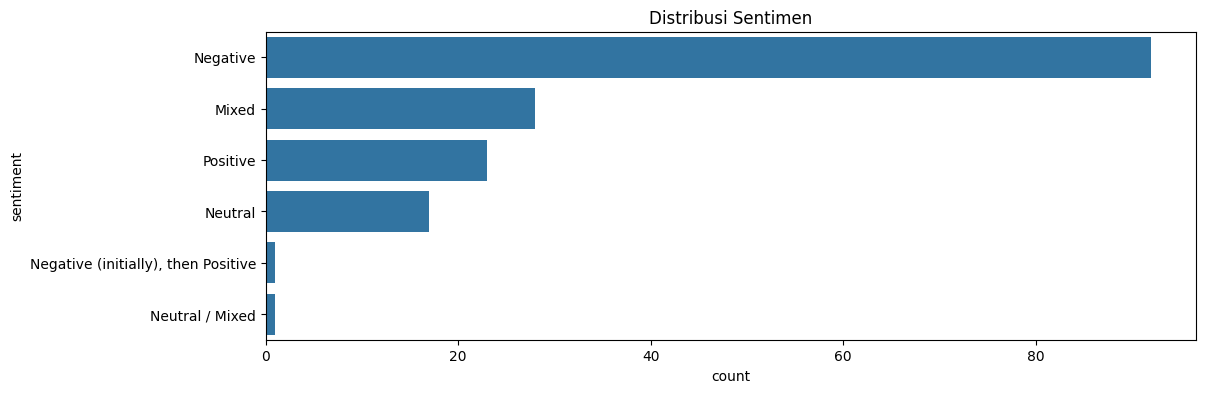

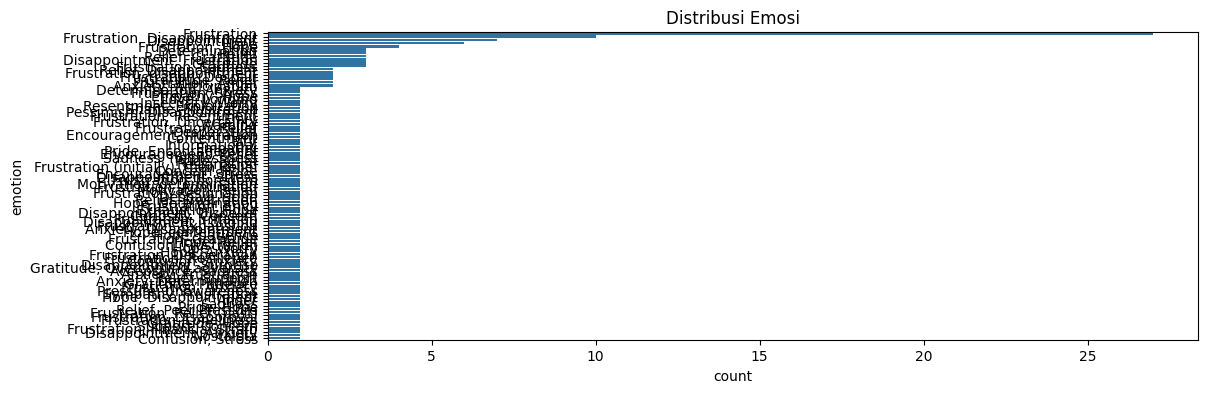

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(data=classified_df, y="sentiment", order=classified_df['sentiment'].value_counts().index)
plt.title("Distribusi Sentimen")
plt.show()

plt.figure(figsize=(12, 4))
sns.countplot(data=classified_df, y="emotion", order=classified_df['emotion'].value_counts().index)
plt.title("Distribusi Emosi")
plt.show()


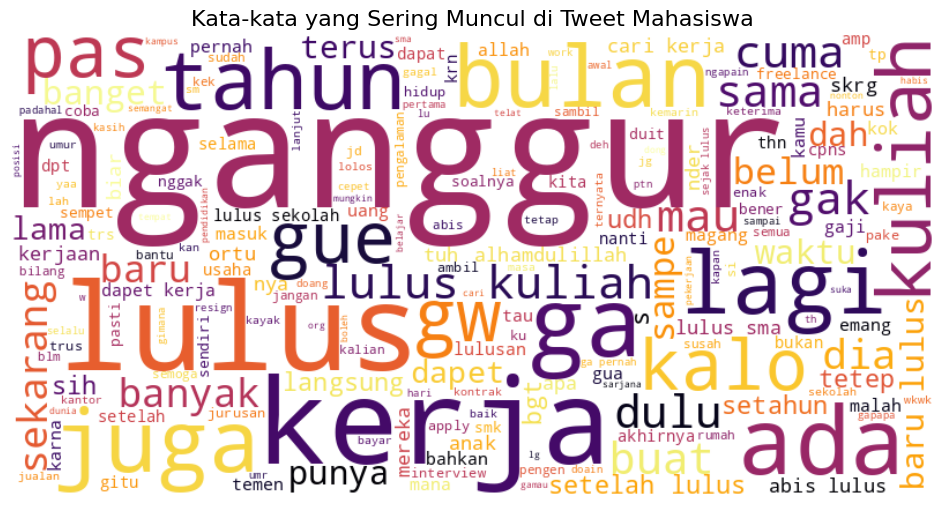

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Gabungkan semua teks tweet
text_data = " ".join(df["clean_text"].dropna().tolist())

# Tambahkan stopwords bahasa Indonesia agar tidak terlalu umum
stopwords = set(STOPWORDS)
stopwords.update([
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "saya", "karena",
    "aja", "udah", "dengan", "bikin", "masih", "lebih", "kalau", "jadi", "bisa", "orang",
    "ke", "yg", "atau", "tapi", "aku", "ya"
])

# Buat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=stopwords, colormap='inferno').generate(text_data)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Kata-kata yang Sering Muncul di Tweet Mahasiswa", fontsize=16)
plt.show()



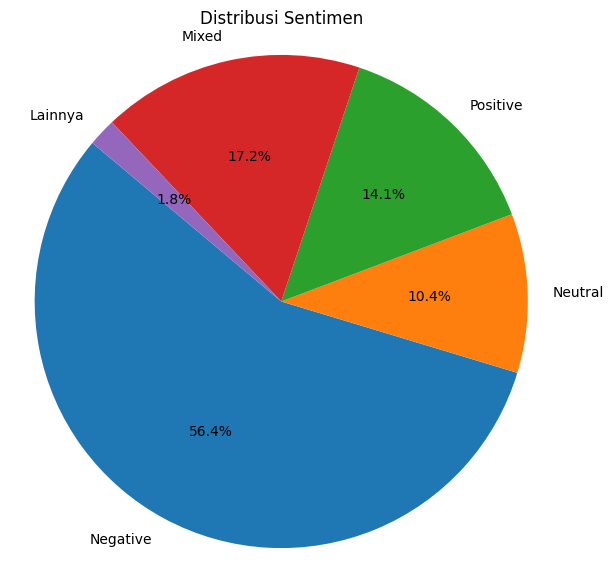

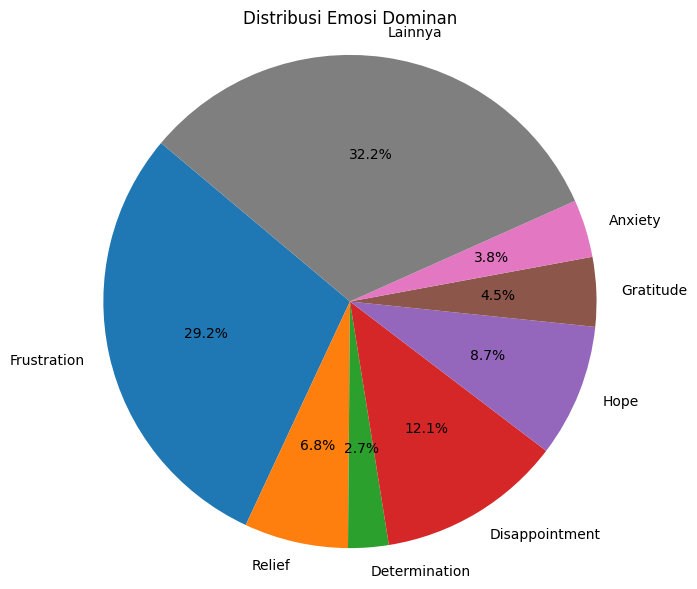

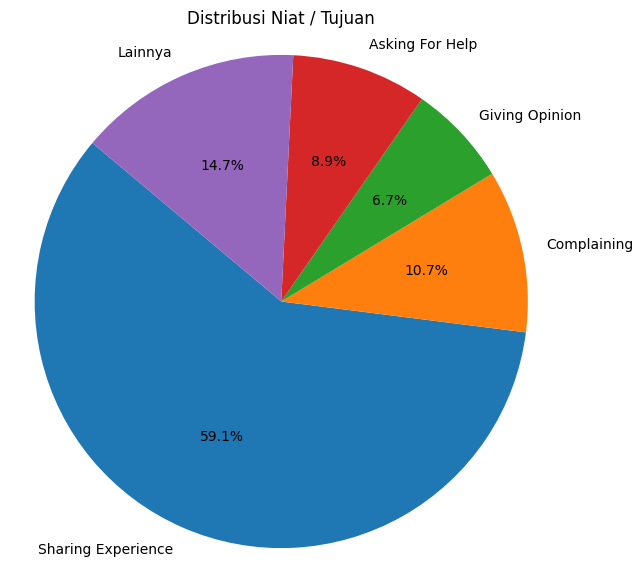

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("classified_tweets.csv")

def count_individual_labels(column):
    all_labels = []
    for entry in df[column].dropna():
        parts = [p.strip().title() for p in str(entry).split(',')]
        all_labels.extend(parts)
    return Counter(all_labels)

def plot_clean_pie(label_counter, title, min_percentage=2.5):
    total = sum(label_counter.values())
    filtered = {k: v for k, v in label_counter.items() if (v / total * 100) >= min_percentage}
    other_total = total - sum(filtered.values())
    if other_total > 0:
        filtered["Lainnya"] = other_total

    labels = list(filtered.keys())
    sizes = list(filtered.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribusi {title}")
    plt.axis('equal')
    plt.show()

# Analisis kolom multi-label
intent_counter = count_individual_labels("intent")
emotion_counter = count_individual_labels("emotion")
sentiment_counter = count_individual_labels("sentiment")

# Plot Pie Chart
plot_clean_pie(sentiment_counter, "Sentimen")
plot_clean_pie(emotion_counter, "Emosi Dominan")
plot_clean_pie(intent_counter, "Niat / Tujuan")


In [ ]:
sentiment_counts = classified_df["sentiment"].value_counts().to_dict()
emotion_counts = classified_df["emotion"].value_counts().to_dict()
intent_counts = classified_df["intent"].value_counts().to_dict()

summary_prompt = f"""
You are an expert AI analyst tasked with writing a high-impact summary of Indonesian youth sentiment regarding their future, economy, and opportunities.

Your insights come from a classified dataset of tweets from students and fresh graduates.
Here are some statistics:
- Sentiment Distribution: {sentiment_counts}
- Top Emotions: {list(emotion_counts.items())[:5]}
- Top Intents: {list(intent_counts.items())[:5]}

Now summarize the **true voice of the youth**, with a focus on:
1. Most dominant emotions and sentiments they express.
2. Common disappointments related to economic hardship, job market unfairness, expensive education, and distrust in the system (government, campus, companies).
3. Patterns of emotional shift (e.g., from hopeful to frustrated or apathetic).
4. Bold but realistic recommendations for universities, government, and employers to rebuild trust and opportunity.

🔍 Be honest and sharp, but respectful.
📌 Write in clear and impactful bullet points.
📊 Avoid repeating data — extract real insight and meaning.
🧠 Use simple, natural English that shows empathy and urgency.
""".strip()


summary = output.invoke(summary_prompt)
print("📊 Summary Output:\n")
print(summary)

with open("summary_output.txt", "w", encoding="utf-8") as f:
    f.write(summary)


📊 Summary Output:

1. **Dominant Emotions & Sentiments**: Indonesian youth express a predominantly negative sentiment, with frustration and disappointment being the most prevalent emotions. Despite this, a small fraction of them (23%) remain hopeful, indicating a glimmer of resilience. The mixed and neutral sentiments suggest uncertainty and indecision.

2. **Common Disappointments**:
   - **Economic Hardship**: Many students grapple with financial struggles, often juggling part-time jobs alongside their studies.
   - **Unfair Job Market**: Fresh graduates lament the lack of opportunities, claiming unfair hiring practices and a disconnect between academic skills and industry demands.
   - **Expensive Education**: The high cost of tertiary education is a significant source of frustration, with many questioning its return on investment.
   - **Distrust in Systems**: Youth express disillusionment with government policies, campus administration, and corporate practices, perceiving them as 